In [2]:
from keras.applications.resnet_v2 import ResNet50V2, ResNet101V2, ResNet152V2, preprocess_input, decode_predictions
from keras.applications.resnet import ResNet50, preprocess_input, decode_predictions


In [4]:
resnet = ResNet152V2(include_top=False, weights='imagenet', input_shape = (150,150,3))


234561536/234545216 [==============================] - 25s 0us/step


In [5]:
from tensorflow.keras.layers import MaxPooling2D, Flatten, Dropout, Dense, BatchNormalization
from tensorflow.keras import Model

x = resnet.output
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dropout(0.5)(x)
x =  Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x =  Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(7, activation='sigmoid')(x)

model = Model(inputs=resnet.input, outputs=x)

In [6]:
for layer in resnet.layers:
    layer.trainable = False
    

----

In [7]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [8]:
def load(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, size=(150, 150))
    return img

In [9]:
d_path = 'D:\AlbumCover/'
img_dataset_cache = pd.read_csv('./dataset/img.csv')
img_dataset = img_dataset_cache.copy()

In [10]:
img_arr = None

for path in img_dataset['path']:
    if img_arr is None:
        img_arr = np.expand_dims(load(d_path + path), axis=0)
    else:
        img_arr = np.append(img_arr, np.expand_dims(load(d_path + path), axis=0), axis=0)
        
#img_arr = img_arr/255.0

In [11]:
pre_facial = pd.read_csv('./dataset/facial.csv')

if 'Unnamed: 0' in pre_facial.columns:
    pre_facial = pre_facial.drop('Unnamed: 0', axis=1)

In [12]:
imsi = pre_facial.copy()

# categorical data to one-hot
fac_input_df = pd.get_dummies(imsi, prefix=['gender', 'dominant_race'])

# Normalization
fac_input_norm = (fac_input_df - fac_input_df.mean()) / fac_input_df.std()

fac_input = np.array(fac_input_norm)

In [13]:
clr_data = pd.read_csv('./dataset/clr.csv')
if 'Unnamed: 0' in clr_data.columns:
    clr_data = clr_data.drop('Unnamed: 0', axis=1)

In [14]:
clr_input = np.array( (clr_data - clr_data.mean())/clr_data.std() )

In [15]:
y_data = pd.read_csv('./dataset/y_label.csv')

y_out = np.array(y_data)

img_arr = img_arr.astype('float64')

In [16]:
import sklearn

img_arr_s = sklearn.utils.shuffle(img_arr, random_state=1234)
fac_input_s = sklearn.utils.shuffle(fac_input, random_state=1234)
clr_input_s = sklearn.utils.shuffle(clr_input, random_state=1234)
y_out_s = sklearn.utils.shuffle(y_out, random_state=1234)

In [17]:
img_arr_test = img_arr_s[900:]
fac_inp_test = fac_input_s[900:]
clr_inp_test = clr_input_s[900:]
y_out_test = y_out_s[900:]

img_arr_s = img_arr_s[:900]
fac_input_s = fac_input_s[:900]
clr_input_s = clr_input_s[:900]
y_out_s = y_out_s[:900]

In [18]:

optimizer = tf.keras.optimizers.RMSprop(lr=0.045, epsilon=1.0, decay=0.9)

model.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['Precision', 'Recall', tf.compat.v1.losses.log_loss, 'BinaryAccuracy'])

c:\Users\cid2r\anaconda3\lib\site-packages\keras\optimizer_v2\rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [19]:
# 성능 기반 스케줄링
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3)

In [20]:
with tf.device("/device:GPU:0"):
    history = model.fit(
        img_arr_s, y_out_s, 
        batch_size=32, 
        epochs=100, 
        validation_split=0.2, 
        callbacks=[lr_scheduler, tf.keras.callbacks.EarlyStopping(patience=10)]
    )

Epoch 1/100
23/23 [==============================] - 18s 301ms/step - loss: 0.8454 - precision: 0.2196 - recall: 0.5525 - log_loss: 0.8450 - binary_accuracy: 0.5446 - val_loss: 0.8961 - val_precision: 0.2577 - val_recall: 0.5425 - val_log_loss: 0.8922 - val_binary_accuracy: 0.6040 - lr: 0.0010
Epoch 2/100
23/23 [==============================] - 3s 133ms/step - loss: 0.5823 - precision: 0.3681 - recall: 0.8078 - log_loss: 0.5817 - binary_accuracy: 0.7018 - val_loss: 0.7510 - val_precision: 0.2552 - val_recall: 0.4980 - val_log_loss: 0.7451 - val_binary_accuracy: 0.6167 - lr: 0.0010
Epoch 3/100
23/23 [==============================] - 3s 133ms/step - loss: 0.4633 - precision: 0.4681 - recall: 0.8487 - log_loss: 0.4631 - binary_accuracy: 0.7893 - val_loss: 0.6511 - val_precision: 0.2597 - val_recall: 0.3522 - val_log_loss: 0.6463 - val_binary_accuracy: 0.6762 - lr: 0.0010
Epoch 4/100
23/23 [==============================] - 3s 132ms/step - loss: 0.3672 - precision: 0.5986 - recall: 0.905

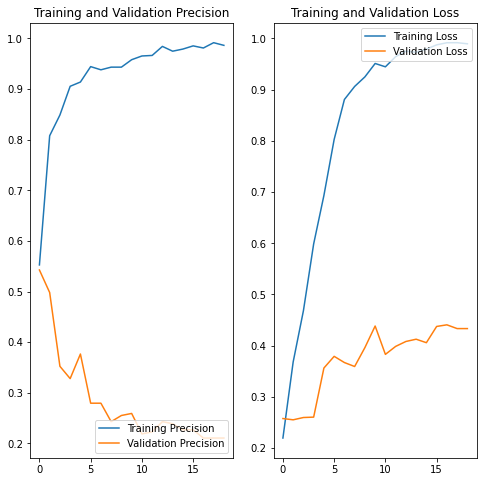

In [21]:
import matplotlib.pyplot as plt

acc = history.history['recall']
val_acc = history.history['val_recall']

loss = history.history['precision']
val_loss = history.history['val_precision']

epochs_range = range(19)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Precision')
plt.plot(epochs_range, val_acc, label='Validation Precision')
plt.legend(loc='lower right')
plt.title('Training and Validation Precision')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [22]:
model.evaluate(img_arr_test,y_out_test)

4/4 [==============================] - 1s 90ms/step - loss: 0.5977 - precision: 0.5316 - recall: 0.2675 - log_loss: 0.5883 - binary_accuracy: 0.8128


[0.597675085067749,
 0.5316455960273743,
 0.2675159275531769,
 0.588341474533081,
 0.8128079175949097]

In [23]:
2/(1/0.53 + 1/0.26)

0.34886075949367096

----

In [127]:
from tensorflow.keras.layers import MaxPooling2D, Flatten, Dropout, Dense, BatchNormalization, Concatenate
from tensorflow.keras import Model

xx = resnet.output
xx = MaxPooling2D(pool_size=(2, 2))(xx)
xx = Flatten()(xx)

real_face_input = tf.keras.layers.Input(shape=(16,))
real_clr_input = tf.keras.layers.Input(shape=(3,))

concat = Concatenate(axis=-1)([xx, real_face_input, real_clr_input])

xx = Dropout(0.5)(concat)
xx =  Dense(512, activation='relu')(xx)
xx = BatchNormalization()(x)
xx =  Dense(256, activation='relu')(xx)
xx = BatchNormalization()(x)
xx = Dense(7, activation='sigmoid')(xx)

model = Model(inputs=[resnet.input,real_face_input,real_clr_input], outputs=xx)

In [128]:
for layer in resnet.layers:
    layer.trainable = False
    

In [129]:

optimizer = tf.keras.optimizers.RMSprop(lr=0.045, epsilon=1.0, decay=0.9)

model.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['Precision', 'Recall', 'BinaryAccuracy'])

c:\Users\cid2r\anaconda3\lib\site-packages\keras\optimizer_v2\rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [130]:
# 성능 기반 스케줄링
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3)

In [131]:
with tf.device("/device:GPU:0"):
    history = model.fit(
        [img_arr_s, fac_input_s,clr_input_s],
        y_out_s, 
        batch_size=32, 
        epochs=100, 
        validation_split=0.2, 
        callbacks=[lr_scheduler, tf.keras.callbacks.EarlyStopping(patience=10)]
    )

Epoch 1/100
23/23 [==============================] - 14s 266ms/step - loss: 0.7341 - precision: 0.2378 - recall: 0.6324 - binary_accuracy: 0.5476 - val_loss: 0.7817 - val_precision: 0.1881 - val_recall: 0.5506 - val_binary_accuracy: 0.4460 - lr: 0.0010
Epoch 2/100
23/23 [==============================] - 3s 135ms/step - loss: 0.6081 - precision: 0.3333 - recall: 0.8687 - binary_accuracy: 0.6470 - val_loss: 0.7340 - val_precision: 0.2101 - val_recall: 0.5385 - val_binary_accuracy: 0.5127 - lr: 0.0010
Epoch 3/100
23/23 [==============================] - 3s 130ms/step - loss: 0.5505 - precision: 0.3806 - recall: 0.9212 - binary_accuracy: 0.7020 - val_loss: 0.7085 - val_precision: 0.2327 - val_recall: 0.5304 - val_binary_accuracy: 0.5651 - lr: 0.0010
Epoch 4/100
23/23 [==============================] - 3s 129ms/step - loss: 0.5135 - precision: 0.4276 - recall: 0.9433 - binary_accuracy: 0.7508 - val_loss: 0.6908 - val_precision: 0.2230 - val_recall: 0.4939 - val_binary_accuracy: 0.5635 - lr

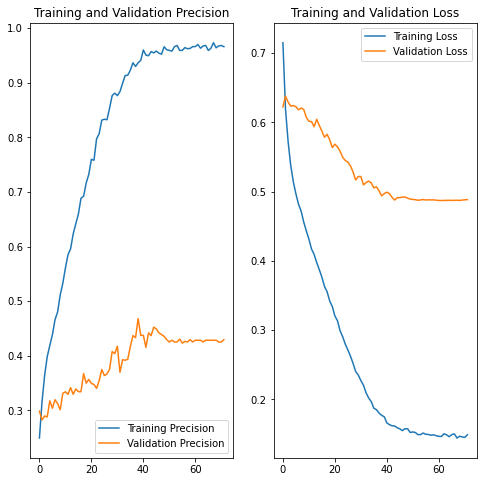

In [31]:
import matplotlib.pyplot as plt

acc = history.history['precision']
val_acc = history.history['val_precision']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(72)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Precision')
plt.plot(epochs_range, val_acc, label='Validation Precision')
plt.legend(loc='lower right')
plt.title('Training and Validation Precision')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [32]:
model.evaluate([img_arr,fac_inp_test,clr_inp_test],y_out_test)

4/4 [==============================] - 1s 96ms/step - loss: 0.5044 - precision: 0.4082 - recall: 0.2548 - log_loss: 0.4993 - binary_accuracy: 0.7845


[0.5043538212776184,
 0.40816327929496765,
 0.25477707386016846,
 0.49927666783332825,
 0.7844827771186829]

In [33]:
2 / (1/0.41 + 1/0.25)

0.3106060606060606

In [132]:
model.save('./models/imsi.h5')

In [133]:
k = model.predict([img_arr,fac_input,clr_input])

In [134]:
k = np.array(k)

In [135]:
kk = k > 0.5

In [177]:
for i in range(len(kk)):
    print(kk[i])

[ True False False False False False False]
[False False False False False False False]
[ True False False False False False False]
[False False False False False False False]
[False False False False False False  True]
[ True False False False False False False]
[ True False False False False False False]
[ True False False False False False False]
[ True False False False False False False]
[ True False False False False False False]
[False False False  True False False False]
[ True False False False False False False]
[False False False False False False False]
[ True False False False False False False]
[ True False False False False False False]
[False False False False False False False]
[ True False False False False False False]
[ True False False False False  True False]
[False False False False False False False]
[ True False False False False False False]
[ True False False False False False False]
[ True False False False False False False]
[ True False False False False F

In [59]:
 yy = y_out > 0.5

In [60]:
from sklearn.metrics import jaccard_score

In [64]:
yy.shape

(1016, 7)

In [136]:
good = [0]

for i in range(1016):
    j = jaccard_score(kk[i],yy[i], average='micro')
    if j > 0.8:
        print(i)
        good.append(i)
    

0
2
5
6
7
8
9
11
13
14
16
19
20
21
22
23
24
25
27
28
29
31
33
34
35
36
37
38
39
40
42
43
44
47
49
50
51
52
54
55
56
57
58
59
60
61
62
63
64
65
66
67
69
70
71
72
73
74
77
78
79
80
83
85
88
89
90
91
92
93
94
95
96
97
99
100
101
102
104
105
106
107
108
109
110
111
112
113
114
115
117
118
120
121
122
123
124
125
126
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
165
166
167
168
169
170
171
172
173
174
175
176
177
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
196
198
199
200
201
202
203
205
206
207
208
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
234
236
237
238
239
240
241
242
243
245
247
248
249
251
252
253
254
255
257
259
261
262
263
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
284
285
287
288
289
290
296
297
298
299
300
301
302
304
305
306
307
308
309
310
314
315
316
319
320
321
322
323
324
326
327
328
329
330
33

In [68]:
good

[0,
 0,
 2,
 6,
 7,
 8,
 9,
 11,
 13,
 14,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 27,
 28,
 29,
 31,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 42,
 43,
 44,
 47,
 49,
 50,
 51,
 52,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 69,
 70,
 71,
 72,
 73,
 74,
 77,
 78,
 79,
 80,
 83,
 85,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 99,
 100,
 101,
 102,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 117,
 118,
 121,
 122,
 123,
 124,
 125,
 126,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 196,
 198,
 199,
 200,
 201,
 202,
 203,
 205,
 206,
 207,
 208,
 209,
 213,
 214,
 215,
 216,
 217

In [150]:
pil_img = tf.keras.preprocessing.image.array_to_img(img_arr[726])

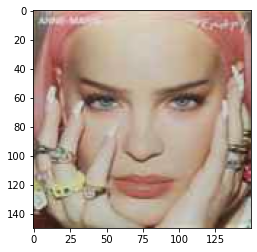

In [151]:
import matplotlib.pyplot as plt

plt.imshow(pil_img)
plt.show()

In [101]:
model.predict([[img_arr[54]],fac_input[54],clr_input[54]])

ValueError: Data cardinality is ambiguous:
  x sizes: 150, 16, 3
Make sure all arrays contain the same number of samples.

In [107]:
img_arr[54]

(191, 150, 150, 3)

In [108]:
img_arr = None

for path in img_dataset['path']:
    if img_arr is None:
        img_arr = np.expand_dims(load(d_path + path), axis=0)
    else:
        img_arr = np.append(img_arr, np.expand_dims(load(d_path + path), axis=0), axis=0)
        
#img_arr = img_arr/255.0

In [182]:
my_img_arr = np.expand_dims(img_arr[54], axis=0)
my_img_arr = np.append(my_img_arr, np.expand_dims(img_arr[831], axis=0), axis=0)
my_img_arr = np.append(my_img_arr, np.expand_dims(img_arr[1007], axis=0), axis=0)
my_img_arr = np.append(my_img_arr, np.expand_dims(img_arr[991], axis=0), axis=0)
my_img_arr = np.append(my_img_arr, np.expand_dims(img_arr[726], axis=0), axis=0)
my_img_arr = np.append(my_img_arr, np.expand_dims(img_arr[396], axis=0), axis=0)
my_img_arr = np.append(my_img_arr, np.expand_dims(img_arr[992], axis=0), axis=0)

np.save('./show/imgarr', my_img_arr)

In [183]:
my_fac_arr = np.expand_dims(fac_input[54], axis=0)
my_fac_arr = np.append(my_fac_arr, np.expand_dims(fac_input[831], axis=0), axis=0)
my_fac_arr = np.append(my_fac_arr, np.expand_dims(fac_input[1007], axis=0), axis=0)
my_fac_arr = np.append(my_fac_arr, np.expand_dims(fac_input[991], axis=0), axis=0)
my_fac_arr = np.append(my_fac_arr, np.expand_dims(fac_input[726], axis=0), axis=0)
my_fac_arr = np.append(my_fac_arr, np.expand_dims(fac_input[396], axis=0), axis=0)
my_fac_arr = np.append(my_fac_arr, np.expand_dims(fac_input[992], axis=0), axis=0)

np.save('./show/facearr', my_fac_arr)

In [184]:
my_clr_arr = np.expand_dims(clr_input[54], axis=0)
my_clr_arr = np.append(my_clr_arr, np.expand_dims(clr_input[831], axis=0), axis=0)
my_clr_arr = np.append(my_clr_arr, np.expand_dims(clr_input[1007], axis=0), axis=0)
my_clr_arr = np.append(my_clr_arr, np.expand_dims(clr_input[991], axis=0), axis=0)
my_clr_arr = np.append(my_clr_arr, np.expand_dims(clr_input[726], axis=0), axis=0)
my_clr_arr = np.append(my_clr_arr, np.expand_dims(clr_input[396], axis=0), axis=0)
my_clr_arr = np.append(my_clr_arr, np.expand_dims(clr_input[992], axis=0), axis=0)

np.save('./show/clrarr', my_clr_arr)

In [185]:
my_y_out = np.expand_dims(y_out[54], axis=0)
my_y_out = np.append(my_y_out, np.expand_dims(y_out[831], axis=0), axis=0)
my_y_out = np.append(my_y_out, np.expand_dims(y_out[1007], axis=0), axis=0)
my_y_out = np.append(my_y_out, np.expand_dims(y_out[991], axis=0), axis=0)
my_y_out = np.append(my_y_out, np.expand_dims(y_out[726], axis=0), axis=0)
my_y_out = np.append(my_y_out, np.expand_dims(y_out[396], axis=0), axis=0)
my_y_out = np.append(my_y_out, np.expand_dims(y_out[992], axis=0), axis=0)

np.save('./show/y', my_y_out)

In [141]:
z = model.predict([my_img_arr, my_fac_arr, my_clr_arr])

In [142]:
z = z > 0.5

In [143]:
z

array([[False,  True, False, False, False, False, False],
       [False, False,  True, False,  True, False, False],
       [False, False, False, False, False,  True, False],
       [ True, False, False, False, False,  True, False],
       [False, False,  True, False,  True, False, False]])

In [144]:
my_y_out > 0.5

array([[False,  True, False, False, False, False, False],
       [False, False,  True, False,  True, False, False],
       [False, False, False, False, False,  True,  True],
       [ True, False, False, False, False,  True, False],
       [False, False, False,  True, False, False, False]])

In [126]:
model.save('my_model')

INFO:tensorflow:Assets written to: my_model\assets
